In [69]:
import numpy as np
import pandas as pd
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt

In [11]:
dirname = '/home/rt2122/Data/scans_extended/connected/'
files = next(os.walk(dirname))[-1]
for file in files:
    df = pd.read_csv(os.path.join(dirname, file))
    df = df.drop(labels=('Unnamed: 0'), axis=1)
    df.to_csv(os.path.join(dirname, file), index=False)

In [70]:
true_catalogs = {cat : 
        pd.read_csv('/home/rt2122/Data/clusters/{cat}.csv'.format(cat=cat)) 
                 for cat in ['planck_z', 'planck_no_z', 'mcxcwp', 'act']}

In [18]:
pz_sc = SkyCoord(ra=true_catalogs['planck_z']['RA']*u.degree,
                dec=true_catalogs['planck_z']['DEC']*u.degree, frame='icrs')
df_sc = SkyCoord(ra=df['tRA']*u.degree, dec=df['tDEC']*u.degree, frame='icrs')

In [71]:
for cat in true_catalogs:
    true_catalogs[cat]['found'] = False
    true_catalogs[cat]['max_pred'] = -1

In [72]:
for file in files:
    df = pd.read_csv(os.path.join(dirname, file))
    df = df[df['status'] == 'tp']
    df.index = np.arange(len(df))
    
    for cat in true_catalogs:
        cur_df = df[df['catalog'] == cat]
        df_sc = SkyCoord(ra=cur_df['tRA']*u.degree, dec=cur_df['tDEC']*u.degree, 
                         frame='icrs')
        true_sc = SkyCoord(ra=true_catalogs[cat]['RA']*u.degree,
                          dec=true_catalogs[cat]['DEC']*u.degree, frame='icrs')
        idx, d2d, _ = true_sc.match_to_catalog_sky(df_sc)
        matched = d2d.degree < 1 / 60
        true_catalogs[cat]['found'].iloc[matched] = True
        true_catalogs[cat]['max_pred'].iloc[matched] = np.array(
            cur_df['max_pred'].iloc[idx[matched]])
        if np.count_nonzero(matched) != len(cur_df):
            print('matched: ', np.count_nonzero(matched), 'tp: ', len(cur_df))

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
true_catalogs['planck_z'].head()

,Name,RA,DEC,z,MSZ,MCXC,RedMAPPer,found,max_pred,mean_rad
0,PSZ2 G000.04+45.13,229.190512,-1.017222,0.1198,3.962411,J1516.5-0056,RMJ151653.9-010506.3,True,0.866953,-1
1,PSZ2 G000.13+78.04,203.558683,20.255990,0.1710,5.122391,J1334.1+2013,RMJ133408.7+201453.0,True,0.852303,-1
2,PSZ2 G000.40-41.86,316.084485,-41.354169,0.1651,5.297053,J2104.3-4120,,True,0.984362,-1
3,PSZ2 G000.77-35.69,307.972844,-40.598725,0.3416,6.333562,J2031.8-4037,,True,0.961392,-1
4,PSZ2 G002.08-68.28,349.632431,-36.332559,0.1400,2.835297,,,True,0.804828,-1


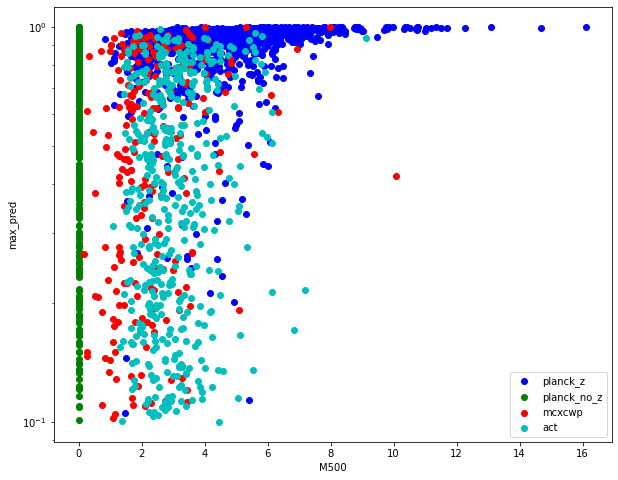

In [88]:
f, ax = plt.subplots(figsize=(10, 8))
for c, cat in zip('bgrc', true_catalogs):
    cur_df = true_catalogs[cat]
    cur_df = cur_df[cur_df['found']]
    s = ax.scatter(cur_df['M500'], cur_df['max_pred'], c=c)
    s.set_label(cat)
ax.set_xlabel('M500')
ax.set_ylabel('max_pred')
plt.yscale('log')
ax.legend()

In [74]:
true_catalogs['planck_z'] = true_catalogs['planck_z'].rename(columns={'MSZ' : 'M500'})
true_catalogs['planck_no_z'] = true_catalogs['planck_no_z'].rename(
    columns={'MSZ' : 'M500'})

In [75]:
true_catalogs['act'] = true_catalogs['act'].rename(columns={'redshift' : 'z'})

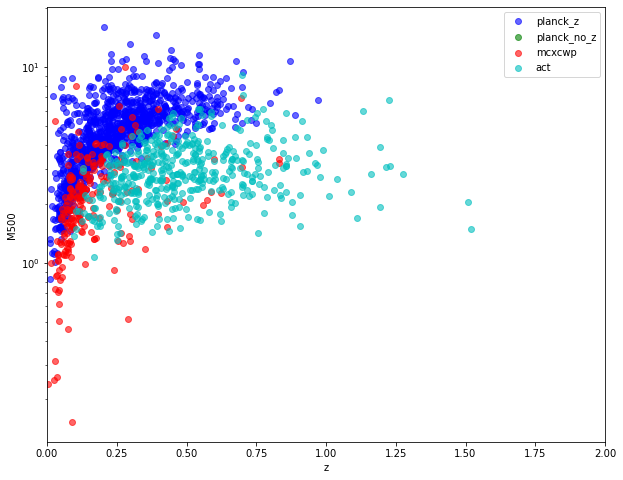

In [85]:
f, ax = plt.subplots(figsize=(10, 8))
for c, cat in zip('bgrc', true_catalogs):
    cur_df = true_catalogs[cat]
    cur_df = cur_df[cur_df['found']]
    s = ax.scatter(cur_df['z'], cur_df['M500'], c=c, alpha=0.6)
    s.set_label(cat)
    cur_df = true_catalogs[cat]
    cur_df = cur_df[cur_df['found'] == False]
    #ax.scatter(cur_df['M500'], cur_df['z'], c=c, alpha=1, marker='v')
ax.set_ylabel('M500')
ax.set_xlabel('z')
plt.xlim(0, 2)
plt.yscale('log')
ax.legend()

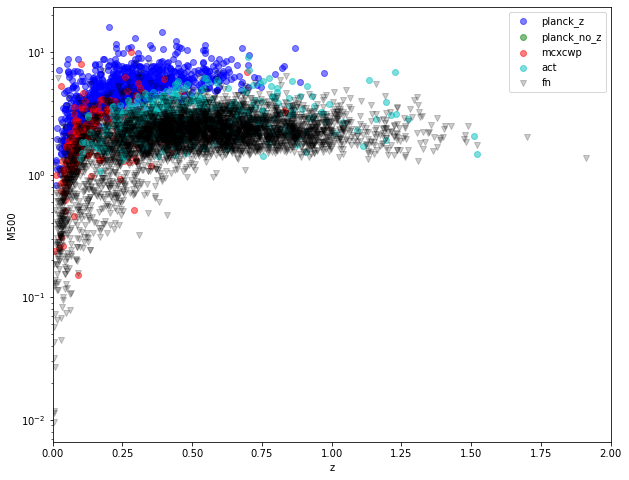

In [92]:
f, ax = plt.subplots(figsize=(10, 8))
for c, cat in zip('bgrc', true_catalogs):
    cur_df = true_catalogs[cat]
    cur_df = cur_df[cur_df['found']]
    s = ax.scatter(cur_df['z'], cur_df['M500'], c=c, alpha=0.5)
    s.set_label(cat)
    cur_df = true_catalogs[cat]
    cur_df = cur_df[cur_df['found'] == False]
    s = ax.scatter(cur_df['z'], cur_df['M500'], c='k', alpha=0.2, marker='v')
s.set_label('fn')
ax.set_ylabel('M500')
ax.set_xlabel('z')
plt.xlim(0, 2)
plt.yscale('log')
ax.legend()

In [68]:
for cat in true_catalogs:
    true_catalogs[cat].to_csv(
        os.path.join('/home/rt2122/Data/clusters/matched', cat) + '.csv', index=False)

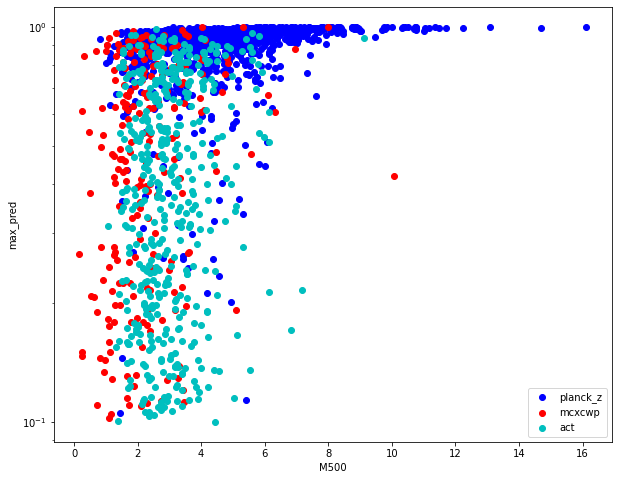

In [89]:
f, ax = plt.subplots(figsize=(10, 8))
for c, cat in zip('bgrc', true_catalogs):
    if cat == 'planck_no_z':
        continue
    cur_df = true_catalogs[cat]
    cur_df = cur_df[cur_df['found']]
    s = ax.scatter(cur_df['M500'], cur_df['max_pred'], c=c)
    s.set_label(cat)
ax.set_xlabel('M500')
ax.set_ylabel('max_pred')
plt.yscale('log')
ax.legend()